# $\Phi$-SO demo : Generating random expressions

In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

In [54]:
# Internal code import
import physo
import physo.learn.random_sampler as rs

Seed

In [55]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

Device

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Quick start
Generating random expressions.

Generating $1000$ random expressions having a length around 12 (with a gaussian soft prior having a scale of 5) with a max length of 30. Here we are using allowing up to input variables $x_1, x_2, x_3, x_4, x_5, x_6$ and one output variable $y$ along with a fixed constant $1$ and three free constants $c_0, c_1, c_2$.

In [57]:
expressions = rs.sample_random_expressions(
    # Batch size
    batch_size=1000,
    # Max length
    max_length=30,
    # Soft length prior
    soft_length_loc = 12.,
    soft_length_scale = 5.,
    # X
    X_names = ["x1", "x2", "x3", "x4", "x5", "x6",],
    # y
    y_name = "y",
    # Fixed constants
    fixed_consts       = [1.],
    # Class free constants
    class_free_consts_names = ["c0", "c1", "c2",],
    # Operations to use
    op_names = ["add", "sub", "mul", "div", "pow", "log", "exp", "cos"],
    # Device to use
    device=device,
    # verbose
    verbose=False
)

### Stats

In [58]:
# Number of expressions generated
print("Number of expressions generated:", expressions.batch_size)
# Expressions lengths
print("Mean expression length:", np.mean(expressions.n_lengths))
# Number of expressions containing input variables
contains_input_vars = expressions.tokens.is_input_var.sum(axis=1)>0
print("Number of expressions containing input variables:", np.sum(contains_input_vars))

Number of expressions generated: 1000
Mean expression length: 12.448
Number of expressions containing input variables: 986


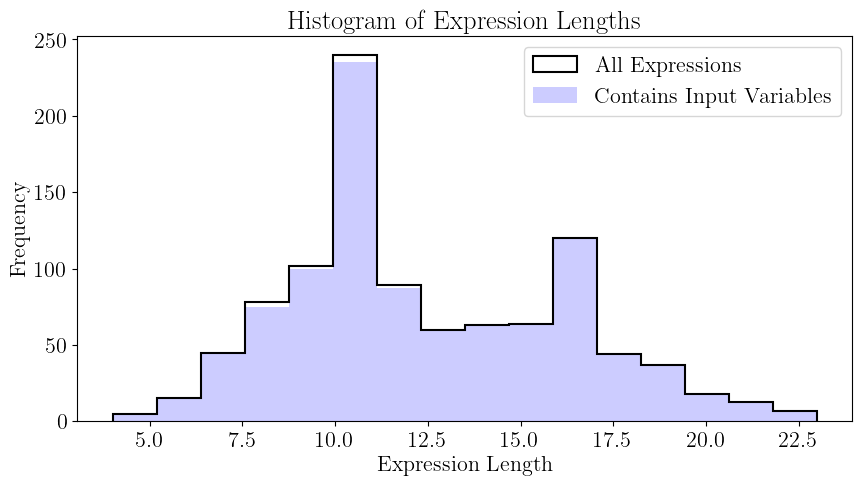

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bins = 16
ax.hist(expressions.n_lengths, bins=bins, histtype='step', color='k', linewidth=1.5, label='All Expressions')
ax.hist(expressions.n_lengths[contains_input_vars], bins=bins, color='b', alpha=0.2, label='Contains Input Variables')
ax.set_xlabel('Expression Length')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_title('Histogram of Expression Lengths')
plt.show()


## More about expression generation

### Using custom priors
Generating random expressions using custom priors the expressions.
See [priors doc](https://physo.readthedocs.io/en/latest/r_features.html#priors) for a detailed description of all available priors.

#### Priors to use

In [60]:
max_length = 40
priors_config = [
    # Uniform probability distribution over tokens by their arities.
    ("UniformArityPrior", None),
    # Hard length prior: all expressions must have a length between min_length and max_length.
    ("HardLengthPrior"  , {"min_length": 4, "max_length": max_length, }),
    # Soft length prior: all expressions have a gaussian prior with mean length and scale.
    ("SoftLengthPrior"  , {"length_loc": 8, "scale": 5, }),
    # Avoiding eg. log(exp(...)) or sqrt((...)^2)
    ("NoUselessInversePrior"  , None),
    # Enforcing dimensional analysis with escape for probs < float epsilon.
    # ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}),
    # Avoiding eg. exp(...+exp(...)) or log(log(...)) etc.
    ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
    ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
    # Avoiding eg. sin(...*cos(...)) or cos(sin(...)) etc.
    ("NestedTrigonometryPrior", {"max_nesting" : 1}),
    # Avoiding 1. appearing more than 3 times in an expression.
    ("OccurrencesPrior", {"targets" : ["1.0",], "max" : [3,] }),
]

#### Generating expressions

In [61]:
expressions = rs.sample_random_expressions(
    # Batch size
    batch_size=1000,
    # Max length
    max_length=max_length,
    # Priors
    priors_config = priors_config,
    # X
    X_names = ["x1", "x2", "x3", "x4", "x5", "x6",],
    # y
    y_name = "y",
    # Fixed constants
    fixed_consts       = [1.],
    # Class free constants
    class_free_consts_names = ["c0", "c1", "c2",],
    # Operations to use
    op_names = ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log", "sin", "cos"],
    # Device to use
    device=device,
    # verbose
    verbose=False
)

#### Stats

In [62]:
# Number of expressions generated
print("Number of expressions generated:", expressions.batch_size)
# Expressions lengths
print("Mean expression length:", np.mean(expressions.n_lengths))
# Number of expressions containing input variables
contains_input_vars = expressions.tokens.is_input_var.sum(axis=1)>0
print("Number of expressions containing input variables:", np.sum(contains_input_vars))

Number of expressions generated: 1000
Mean expression length: 11.989
Number of expressions containing input variables: 948


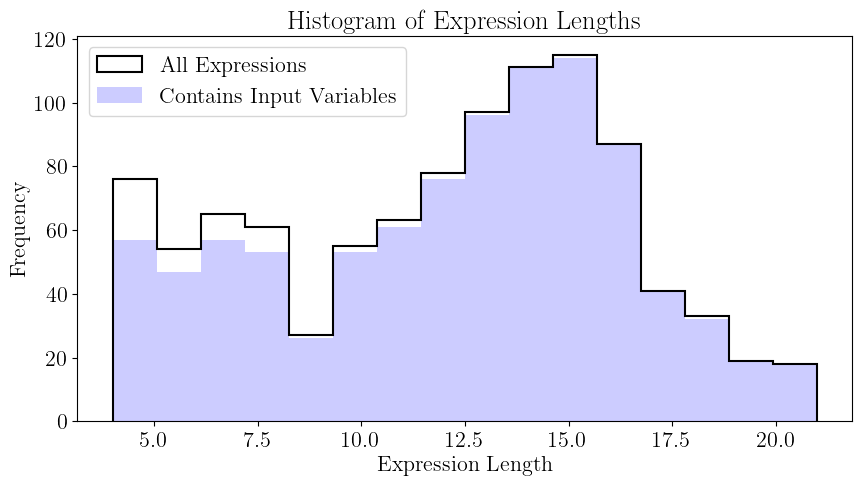

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bins = 16
ax.hist(expressions.n_lengths, bins=bins, histtype='step', color='k', linewidth=1.5, label='All Expressions')
ax.hist(expressions.n_lengths[contains_input_vars], bins=bins, color='b', alpha=0.2, label='Contains Input Variables')
ax.set_xlabel('Expression Length')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_title('Histogram of Expression Lengths')
plt.show()


### Obeying Dimensional Analysis Rules
Generating random expressions obeying dimensional analysis rules.



Given variables $l$ (length) and $t$ (time), we want to generate $1000$ expressions for the output variable $y$ (dimensionless) using fixed constants and free constants $L$ (length) and $f$ (frequency). The operations allowed are addition, subtraction, multiplication, division, power, logarithm, exponential, and cosine.

__DA side notes__:

Here we are allowing the use of a fixed constant $1$ of dimension $L^{0}, T^{0}, M^{0}$ (ie dimensionless) and free constants $L$ (dimension $L^{1}, T^{0}, M^{0}$) and $f$ (dimension $L^{0}, T^{-1}, M^{0}$).

It should be noted that here the units vector are of size 3 (eg: `[1, 0, 0]`) as in this example the variables have units dependent on length, time and mass only.
However, units vectors can be of any size $\leq 7$ as long as it is consistent across X, y and constants, allowing the user to express any units (dependent on length, time, mass, temperature, electric current, amount of light, or amount of matter).
In addition, dimensional analysis can be performed regardless of the order in which units are given, allowing the user to use any convention ([length, mass, time] or [mass, time, length] etc.) as long as it is consistent across X,y and constants.

In [64]:
expressions = rs.sample_random_expressions(
        # Input variables
        X_names = ["l", "t"],
        X_units = [[1,0,0], [0,1,0]],
        # Output variable
        y_name  = "y",
        y_units = [0,0,0],
        # Fixed constants
        fixed_consts       = [1.],
        fixed_consts_units = [[0,0,0]],
        # Free constants
        class_free_consts_names    = ["L", "f",],
        class_free_consts_units    = [[1,0,0], [0,-1,0]],
        class_free_consts_init_val = [1., 1.],
        # Operations to use
        op_names = ["add", "sub", "mul", "div", "log", "exp", "cos"],
        # Device to use
        device=device,
        # verbose
        verbose=False,
                )

#### Stats

In [65]:
# Number of expressions generated
print("Number of expressions generated:", expressions.batch_size)
# Expressions lengths
print("Mean expression length:", np.mean(expressions.n_lengths))
# Number of physically correct expressions
print("Number of physically correct expressions:", np.sum(expressions.is_physical))
# Number of expressions containing input variables
contains_input_vars = expressions.tokens.is_input_var.sum(axis=1)>0
print("Number of expressions containing input variables:", np.sum(contains_input_vars))

Number of expressions generated: 1000
Mean expression length: 27.68
Number of physically correct expressions: 354
Number of expressions containing input variables: 938


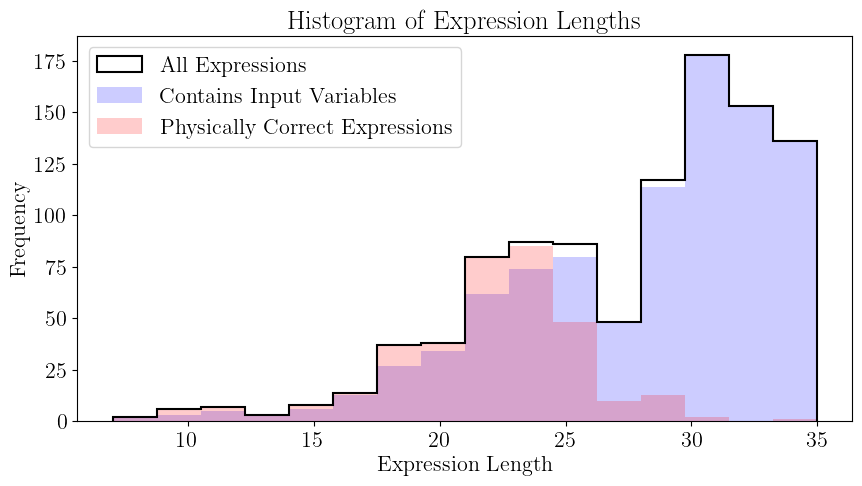

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bins = 16
ax.hist(expressions.n_lengths, bins=bins, histtype='step', color='k', linewidth=1.5, label='All Expressions')
ax.hist(expressions.n_lengths[contains_input_vars], bins=bins, color='b', alpha=0.2, label='Contains Input Variables')
ax.hist(expressions.n_lengths[expressions.is_physical], bins=bins, color='r', alpha=0.2, label='Physically Correct Expressions')
ax.set_xlabel('Expression Length')
ax.set_ylabel('Frequency')
ax.legend()
ax.set_title('Histogram of Expression Lengths')
plt.show()


## Accessing expressions properties

In [67]:
expressions = rs.sample_random_expressions(
    # Batch size
    batch_size=1000,
    # Max length
    max_length=30,
    # Soft length prior
    soft_length_loc = 12.,
    soft_length_scale = 5.,
    # X
    X_names = ["x1", "x2", "x3", "x4", "x5", "x6",],
    # y
    y_name = "y",
    # Fixed constants
    fixed_consts       = [1.],
    # Class free constants
    class_free_consts_names = ["c0", "c1", "c2",],
    # Operations to use
    op_names = ["add", "sub", "mul", "div", "pow", "log", "exp", "cos"],
    # Device to use
    device=device,
    # verbose
    verbose=False
)

### Randomizing free parameter values

In [68]:
# Free constants values are stored in :
print(expressions.free_consts)
# They can be sent to the device via:
expressions.free_consts.to(device)
# Values are stored in :
print(expressions.free_consts.class_values)
print(expressions.free_consts.class_values.shape)

FreeConstantsTable
 -> Class consts (['c0' 'c1' 'c2']) : (1000, np.int64(3))
 -> Spe consts   ([]) : (1000, np.int64(0), 1)
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
torch.Size([1000, 3])


Let's give random values to the free constants.

In [69]:
expressions.free_consts.class_values = torch.rand((expressions.batch_size, expressions.free_consts.n_class_free_const), device=device)
print(expressions.free_consts.class_values)
print(expressions.free_consts.class_values.shape)

tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009],
        [0.2566, 0.7936, 0.9408],
        ...,
        [0.4994, 0.5895, 0.3921],
        [0.6545, 0.1140, 0.2252],
        [0.8451, 0.0134, 0.5785]])
torch.Size([1000, 3])


### Inspecting an expression

Let's inspect expression number 21 of the batch.

In [70]:
expr = expressions.get_prog(21)

Showing expression in all available formats:

In [71]:
print("Infix str:\n", (expr.get_infix_str()))

Infix str:
 (log(cos((x2*c2)))*cos(x6))


Prefix notation:
 [mul log cos mul x2 c2 cos x6]
Sympy:
 log(cos(c2*x2))*cos(x6)
Infix representation str:
 (log(cos((x2*c2)))*cos(x6))
Pretty
:
log(cos(c₂⋅x₂))⋅cos(x₆)
Latex:
 \log{\left(\cos{\left(c_{2} x_{2} \right)} \right)} \cos{\left(x_{6} \right)}


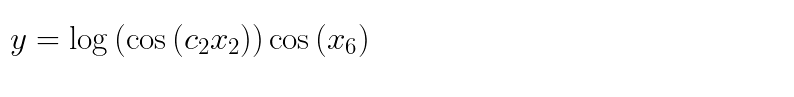

Image:
 None


In [72]:
print("Prefix notation:\n", expr)
print("Sympy:\n", (expr.get_infix_sympy()))
print("Infix representation str:\n", (expr.get_infix_str()))
print("Pretty\n:")
print(expr.get_infix_pretty())
print("Latex:\n", expr.get_infix_latex())
print("Image:\n", expr.show_infix())

Expressions can also be showed with evaluated constants:

In [73]:
print(expr.get_infix_sympy(evaluate_consts=True)[0])

log(cos(0.395829260349274*x2))*cos(x6)


### Evaluating an expression


Free consts: tensor([[0.3278, 0.6532, 0.3958]])


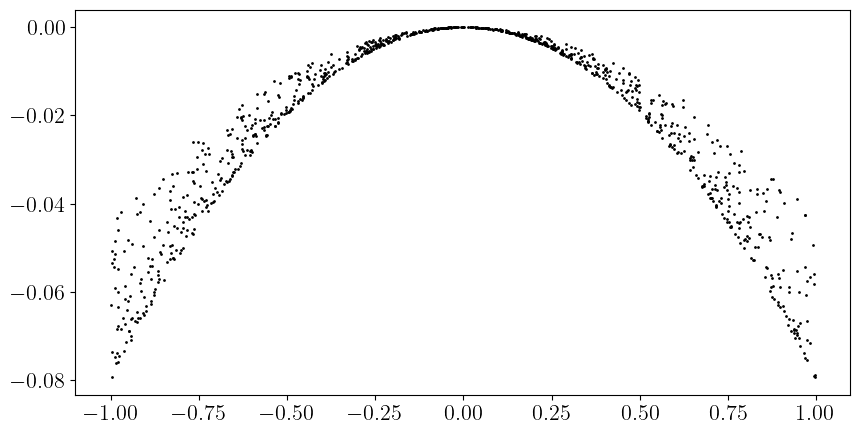

In [74]:
# Making synthetic data
n_samples = 1000
X = torch.tensor(np.random.uniform(-1, 1, size=(6, n_samples))).to(device)
# Evaluating the expression
y = expr(X)
# Showing free constants values
print("Free consts:", expr.free_consts.class_values)
# Figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(X[1].cpu().numpy(), y.detach().cpu().numpy(), 'k.', markersize=2, label='Data')


### Optimizing free parameters of an expression

Note that free constant optimization is typically faster on the CPU.

The library of available tokens depends on the config used to generate the expressions, it can be accessed via the `library` attribute of the expressions object.

In [75]:
lib = expressions.library
print(lib)

[add sub mul div pow log exp cos 1.0 c0 c1 c2 x1 x2 x3 x4 x5 x6 y dummy -]


In [76]:
# Encoding : dict of token names to indices
print(lib.lib_name_to_idx)

{np.str_('add'): 0, np.str_('sub'): 1, np.str_('mul'): 2, np.str_('div'): 3, np.str_('pow'): 4, np.str_('log'): 5, np.str_('exp'): 6, np.str_('cos'): 7, np.str_('1.0'): 8, np.str_('c0'): 9, np.str_('c1'): 10, np.str_('c2'): 11, np.str_('x1'): 12, np.str_('x2'): 13, np.str_('x3'): 14, np.str_('x4'): 15, np.str_('x5'): 16, np.str_('x6'): 17, np.str_('y'): 18, np.str_('dummy'): 19, np.str_('-'): 20}


In [77]:
print("Number of choosable tokens in the library:", lib.n_choices)
print("Token idx used for padding after expression:", lib.invalid_idx)

Number of choosable tokens in the library: 18
Token idx used for padding after expression: 20


Tokens are stored in the `tokens` attribute of the expressions object.
Let's access all tokens of all expressions in the batch.

In [78]:
print("Encoded tokens:")
print(expressions.tokens.idx)                    # (batch_size, max_length)
print("Tokens as str:")
expressions.idx_as_names(expressions.tokens.idx) # (batch_size, max_length)

Encoded tokens:
[[ 1  2 10 ... 20 20 20]
 [ 0  1 14 ... 20 20 20]
 [ 1  8  5 ... 20 20 20]
 ...
 [ 1 17  2 ... 20 20 20]
 [ 3  0 15 ... 20 20 20]
 [ 6  0 11 ... 20 20 20]]
Tokens as str:


array([['sub', 'mul', 'c1', ..., '-', '-', '-'],
       ['add', 'sub', 'x3', ..., '-', '-', '-'],
       ['sub', '1.0', 'log', ..., '-', '-', '-'],
       ...,
       ['sub', 'x6', 'mul', ..., '-', '-', '-'],
       ['div', 'add', 'x4', ..., '-', '-', '-'],
       ['exp', 'add', 'c2', ..., '-', '-', '-']],
      shape=(1000, 30), dtype='<U5')